Author: Raúl Larrubia Sobrino

Let

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} \left((1 - x_i)^2 + K(x_{i+1} - x_i^2)^2\right)
$$

Use the steepest descent gradient method to find the optimum of $f(x)$ for:

- (i) \( N = 2 \), \( K = 2 \)

- (ii) \( N = 2 \), \( K = 1000 \)

- (iii) \( N = 10 \), \( K = 100 \)

## The Rosenbrok Function

In [123]:
import numpy as np

def Rosenbrok_de_K(K:int):
    """
    Returns the Rosenbrok for a given K parameter

    Args:
        K (int): function parameter
    """
    def f(x:list):
        sum = 0
        for i in range(len(x) - 1):
            sum += (1 - x[i]) ** 2 + K * (x[i + 1] - x[i]**2) ** 2
        return sum
    return f

## Buliding the gradient optimizer

Programming a simple gradient steepst descent optimizer with an optioninal parameter to ensure meeting wolf conditions in each step.  

- Advantages: Simple to implement and efficient for basic functions.
- Disadvantes: Some parameters must be manually tuned. Poor parameter selection can lead to issues like infinite loops, particularly when the step size is too large compared to the distance to the minimum. This can cause the algorithm to oscillate around the minimum without converging. To address this, adaptive methods, such as dynamic step adjustment or value limits, can be employed to prevent stagnation or excessive jumping.

In [124]:
from autograd import grad

def check_wolf_conditions(f_x:float, f_x0:float, der_x:float, der_x0:float, alfa:float, mu1:float, mu2:float):
    """
    Checks if wolf conditions are met for a certain alpha displacement over the directional derivate.

    Args:
        f_x (float): value of the function for alpha displacement over x0
        f_x0 (float): value of the function for original point
        der_x (float): derivative of the function evaluated on check point
        der_x0 (float): derivative of the function on x0
        alfa (float): displacement with respect to x0 over gradient direction
        mu1 (float): parameter for sufficient decrease condition
        mu2 (float): parameter for sufficient cruvature condition

    Returns:
        np.boolean: np.True if both conditons are met np.False otherwise
    """
    sufficient_decrease = f_x <= f_x0 + alfa * mu1 * der_x
    sufficient_curvature = np.abs(der_x) <= mu2 * np.abs(der_x0)
    return sufficient_decrease and sufficient_curvature

def linesearch(f, x0:list, pk, d_alfa:float=None, mu1:float=None, mu2:float=None, apply_wolf:bool=None):
    """
    Returns the displacement over the derivative line to find the optimal point

    Args:
        f (function): function to optimize
        x0 (list): starting point (gradient known)
        pk (np.array): unitary vector of the direction of descent gradient
        d_alfa (float, optional): alpha step to perfom. Defaults to 0.01.
        mu1 (float): parameter for sufficient decrease condition. Defaults to 0.05.
        mu2 (float): parameter for sufficient cruvature condition. Defaults to 0.07.
        apply_wolf (boolean, optional): Finds alpha taht meets wolf conditions. Defaults to False.

    Returns:
        alfa: displacement over the pk vector to approah minmal value
    """
    # Default values if not provided
    True if apply_wolf == None else False
    d_alfa = 0.01 if d_alfa == None else d_alfa
    mu1 = 0.5  if mu1 == None else mu1
    mu2 = 0.7  if mu2 == None else mu2
    
    if apply_wolf == True:
        # ensuring wolf conditions
        alfa = 0
        gradient_f = grad(f)
        f_x0 = f(x0)
        der_x0 = np.dot(gradient_f(x0), pk)
        wolf_conditions = False
        while wolf_conditions == False:
            alfa = alfa + d_alfa
            grad_x = gradient_f(x0 + alfa * pk)
            f_x = f(x0+ alfa * pk)
            der_x = np.dot(grad_x, pk)
            wolf_conditions = check_wolf_conditions(f_x, f_x0, der_x, der_x0, alfa, mu1, mu2)
    else:
        # without ensuring wolf conditions
        alfa = d_alfa
    return alfa

In [125]:
def gradient_optimizer(f, x0:list, N_max:int, d_alfa:float=None, apply_wolf:bool=None):
    """
    Optimizer based on steepest gradient descent, using linearseah where wolf conditions can be forced or not.

    Args:
        f (function): function to 
        x0 (list): initial value
        N_max (int): max number of steps
        d_alfa (float, optional): incremental of displacament in gradient direction. Defaults to 0.01   .
        apply_wolf (bool, optional): Forces a d_alfa that ensures Wolf conditions. Defaults to False.

    Returns:
        list, float, int  : step new points, gradient nomr in last point, number of steps performed
    """

    # initializing values
    step = 0 
    x_ = [x0]               # stores each new point 
    gradient_f = grad(f)
    gradiente = np.array(gradient_f(x0))

    while step < N_max:
        gradiente = np.array(gradient_f(x_[-1]))
        pk = -gradiente / np.linalg.norm(gradiente)
        alfa_k = linesearch(f,  x_[-1], pk, d_alfa=d_alfa, apply_wolf=apply_wolf)
        x_new = x_[-1] + alfa_k * pk 

        x_.append(x_new)
        step += 1
    return x_, np.linalg.norm(gradiente, ord=np.inf), step

## Functions for plotting


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi'] = 300

def graph_combined(f, x_lim:list, y_lim:list, N_points:int, x_points=None, y_points=None, z_points=None):
    """Creates both a 3D surface plot and a 2D contour plot of a function. If points are provided, adds them to both plots.

    Args:
        f (function): function to plot
        x_lim (list): limits on x axis
        y_lim (list): limits on y axis
        N_points (int): Points to evaluate the function in each dimension
        x_points (array, optional): x coordinates of points. Defaults to None.
        y_points (array, optional): y coordinates of points. Defaults to None.
        z_points (array, optional): z coordinates of points. Defaults to None.

    Returns:
        None
    """
    
    # Defining the range
    x = np.linspace(x_lim[0], x_lim[1], num=N_points)
    y = np.linspace(y_lim[0], y_lim[1], num=N_points)

    # Creating mesh and evaluating points
    X, Y = np.meshgrid(x, y)
    Z = np.array([f([x_val, y_val]) for x_val, y_val in zip(X.ravel(), Y.ravel())])
    Z = Z.reshape(X.shape)

    # Creating the figure with subplots
    fig1 = plt.figure(figsize=(12, 6))
    ax1 = fig1.add_subplot(121, projection='3d')
    norm = mcolors.LogNorm(vmin=Z.min() + 1e-5, vmax=Z.max()) 

    # Plotting the 3D surface
    surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', norm=norm, edgecolor='none', alpha=1)

    ax1.set_title('3D Surface plot of f(x, y)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('f(x, y)')

    # If points are provided, add them to the 3D plot
    if x_points is not None and y_points is not None and z_points is not None:
        # Slightly elevate the points above the surface
        ax1.plot3D(x_points, y_points, z_points, color='black', marker='o', markersize=5, linewidth=2, zorder=3)

    # Creating the contour plot
    ax2 = fig1.add_subplot(122)
    contour = ax2.contourf(X, Y, Z, levels=30, cmap='coolwarm', norm=norm)
    ax2.contour(X, Y, Z, levels=30, colors='black', linewidths=0.5)
    fig1.colorbar(contour, ax=ax2, shrink=0.6, aspect=10)
    ax2.set_title('Contour plot of f(x, y)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal')
    
    # If points are provided, add them to the contour plot
    if x_points is not None and y_points is not None:
        ax2.plot(x_points, y_points, color='black', marker='o', markersize=5, linewidth=2)

    plt.subplots_adjust(wspace=0.4)
    plt.show()

In [127]:
def print_optimization_results(f, method:str, x_optimal:list, error:float, step_number:int):
    """
    displays on terminal the some key statistics for the optimizacion process

    Args:
        f (function): funcition to optimize
        x_optimal (list): optimal point
        method (str): name of the optimization method
        error (float): norm of the gradient of the function evalueted in the last point
        step_number (int): number of the steps taken for the optimization process
    """
    print("OPTIMIZATION WITH " + method)
    print('Optimal point: ', x_optimal)
    print('Function value in optimal point: ', f(x_optimal))
    print('Error: ', error)
    print('Number of iterations: ', step_number)
    print("")

## Rosenbrok funciton for 2 variables K=2

### Visualizing the function

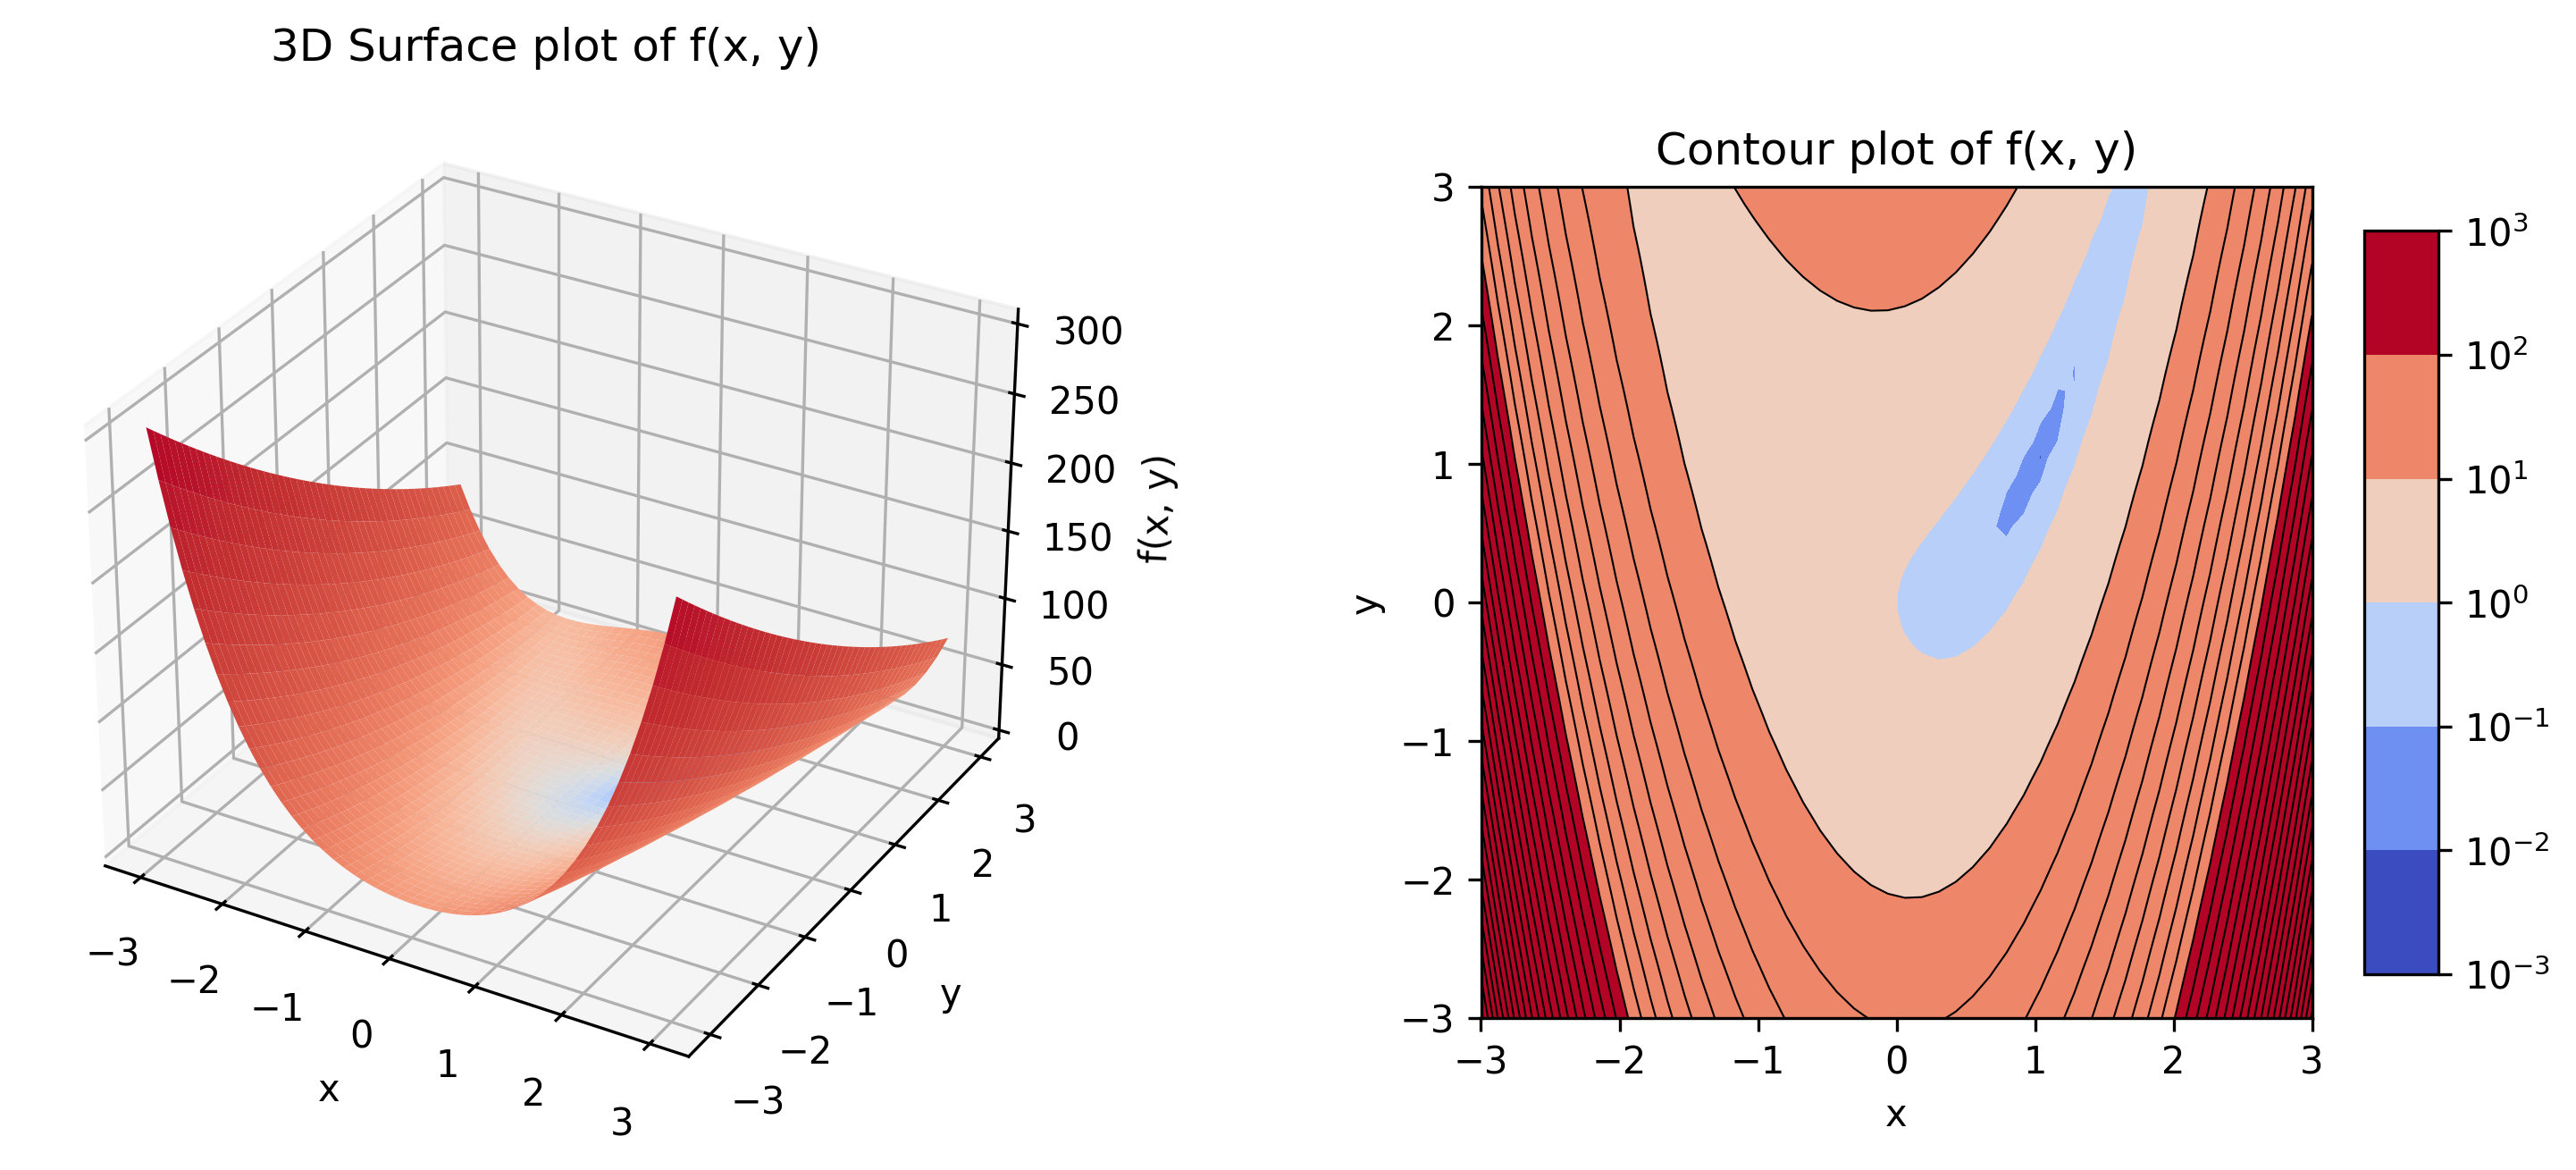

In [128]:
Rosenbrok_K2 = Rosenbrok_de_K(2)
x_lim = [-3, 3]
y_lim = [-3, 3]

graph_combined(Rosenbrok_K2, x_lim, y_lim, N_points = 50)

### Finding the optimal 

In [129]:
x0 = [-2.5, 2.5]  # initial point

# Steepest descendt
x_, error, steps = gradient_optimizer(Rosenbrok_K2, x0, N_max=50, d_alfa=0.001, apply_wolf=True)
print_optimization_results(Rosenbrok_K2,"STEEPEST DESCENDT", x_[-1], error, steps)

# BGS 
from scipy.optimize import minimize
result = minimize(Rosenbrok_K2, x0, method='BFGS')
print_optimization_results(Rosenbrok_K2, "BGS", result.x, np.linalg.norm(grad(Rosenbrok_K2)(result.x), ord=np.inf), result.nit)

OPTIMIZATION WITH STEEPEST DESCENDT
Optimal point:  [0.96340761 0.91969703]
Function value in optimal point:  0.0014820513699883426
Error:  0.047019574009210974
Number of iterations:  50

OPTIMIZATION WITH BGS
Optimal point:  [0.99999964 0.99999919]
Function value in optimal point:  1.451967512952712e-13
Error:  3.2586477649587664e-07
Number of iterations:  15



For this function, the steepest descent method performs adequately. Increasing precision can be achieved by reducing the step size (alpha), but this requires a corresponding increase in the number of iterations, leading to higher computational costs. With a smaller step size, each iteration covers less distance, making it less likely to converge quickly to the minimum. Conversely, increasing the number of iterations for a fixed step size (alpha) eventually reaches a point of diminishing returns, as previously noted.

In contrast, when compared to a professionally implemented algorithm using the BFGS method, the steepest descent method shows minimal improvement, highlighting the efficiency and effectiveness of more advanced optimization techniques like BFGS.

### Representing the optimization trayectory

The following figures illustrate the optimal progression over the course of the steps.

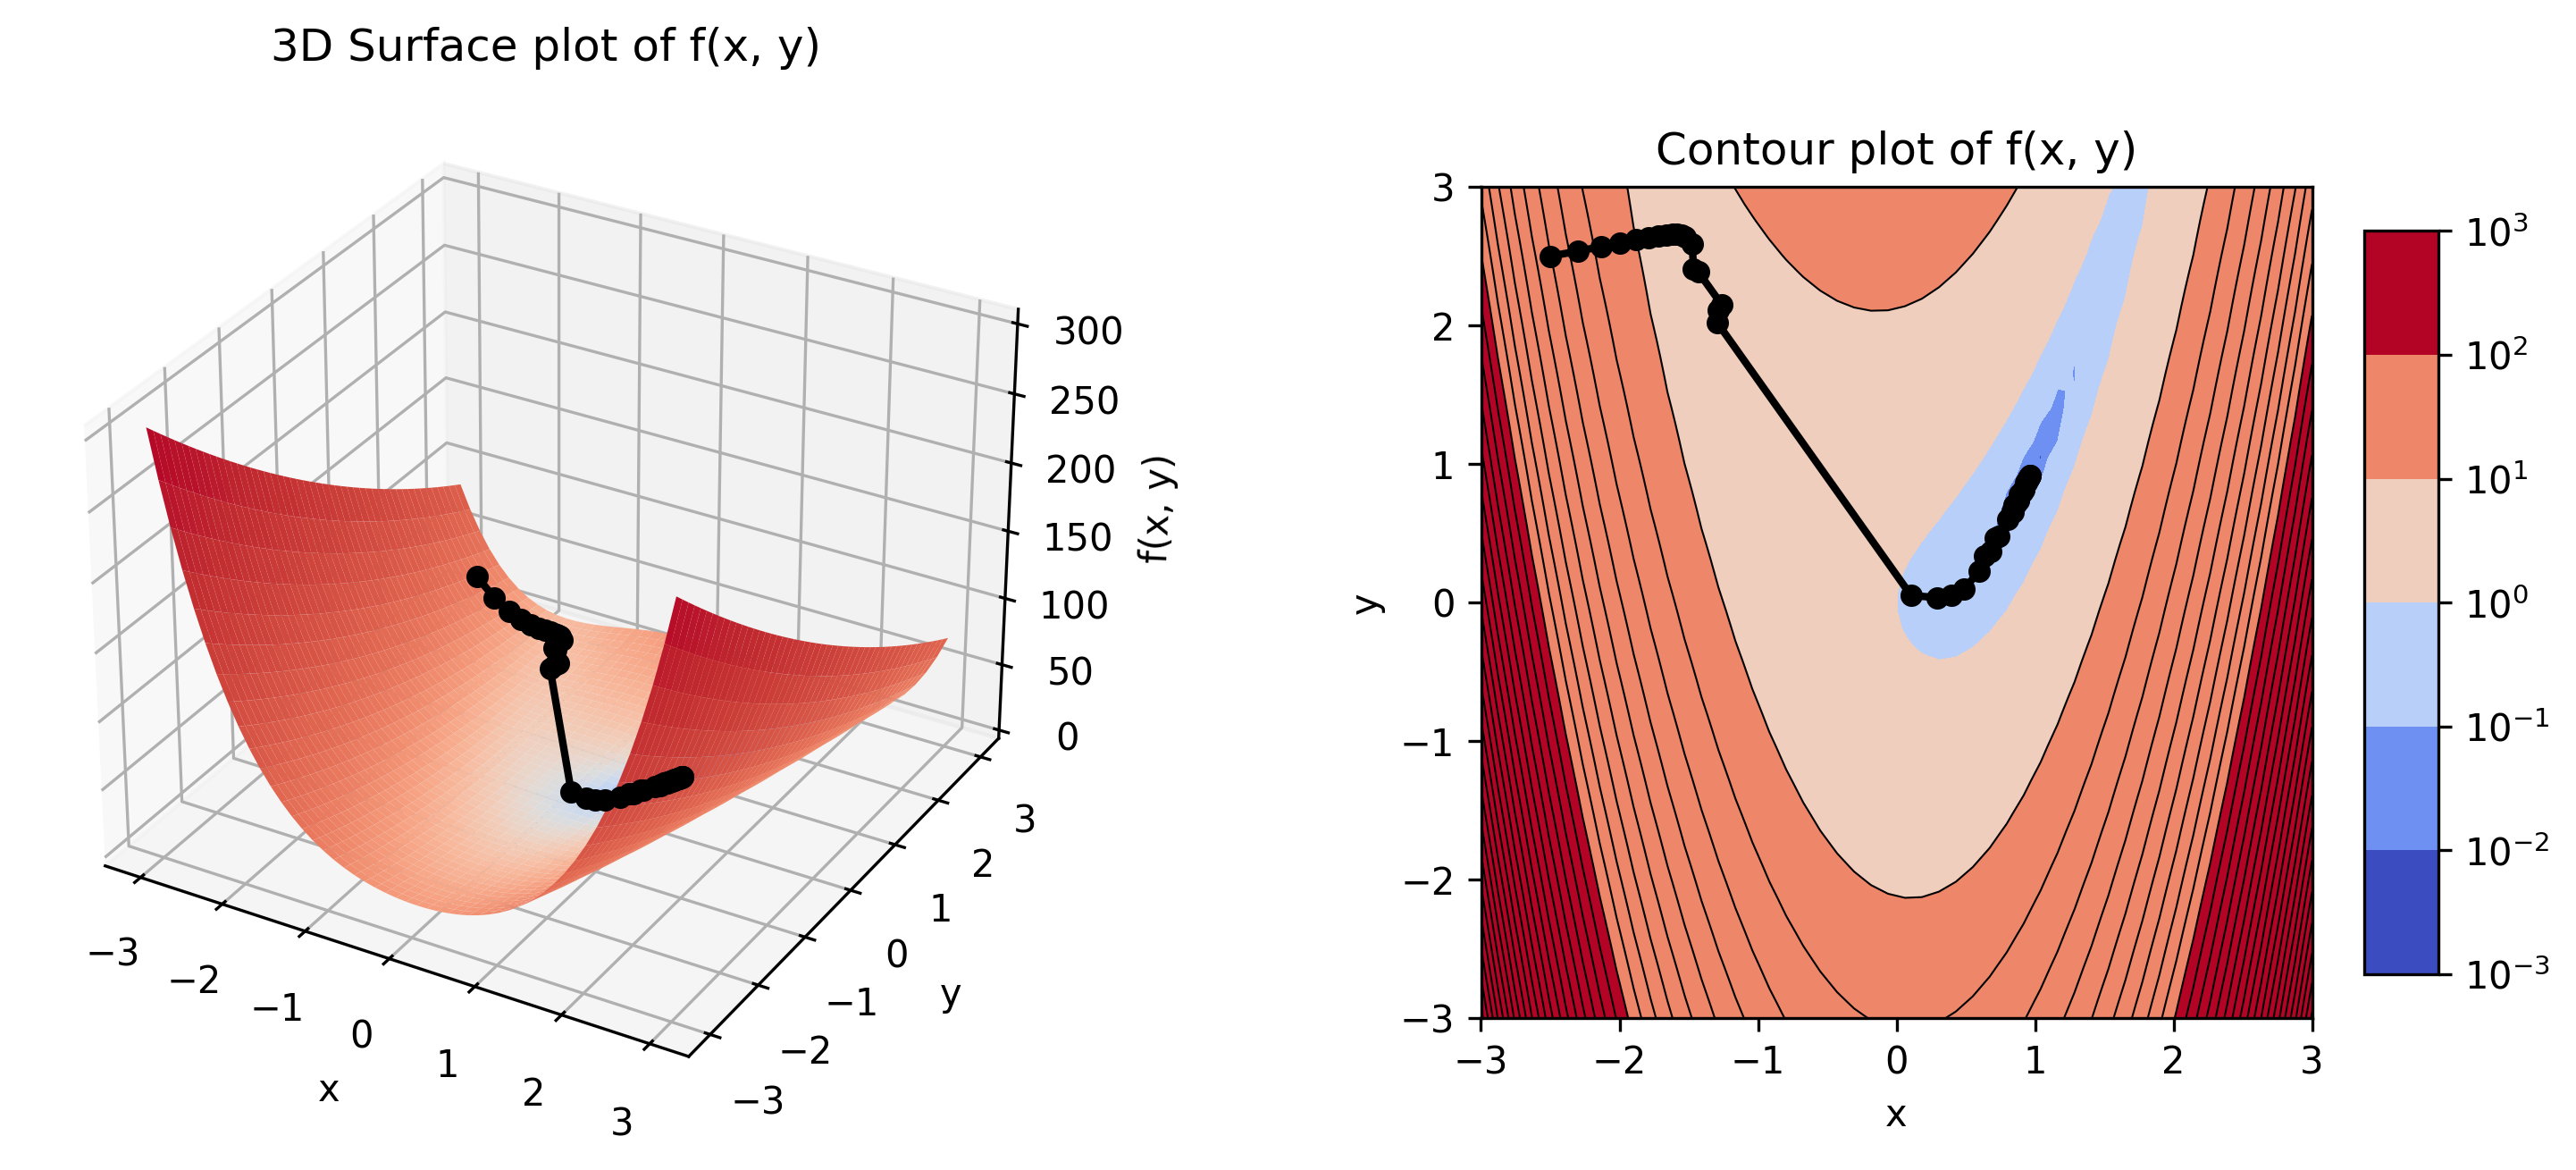

In [130]:
# Optimal points for each step
x_points = np.array([point[0] for point in x_])
y_points = np.array([point[1] for point in x_])
z_points = np.array([Rosenbrok_K2(point) for point in x_])  

## Plots
fig = graph_combined(Rosenbrok_K2, x_lim, y_lim, N_points=50, x_points=x_points, y_points=y_points, z_points=z_points)

## Rosenbrok function with 2 variables and K = 1000

When using the parameter K = 1000 in the Rosenbrock function for two variables, the nature of the function causes values to increase exponentially as you move further from the origin, resulting in extremely large function values.

The enormous differences in the function values along directions makes it challenging for certain algorithms to progress, as the gradient becomes very small over short distances, preventing efficient convergence to the minimum. This often necessitates using smaller step sizes, which leads to significantly higher computation times.

### Visualizing the function

In [131]:
f_Rosenbrok_K1000 = Rosenbrok_de_K(1000)

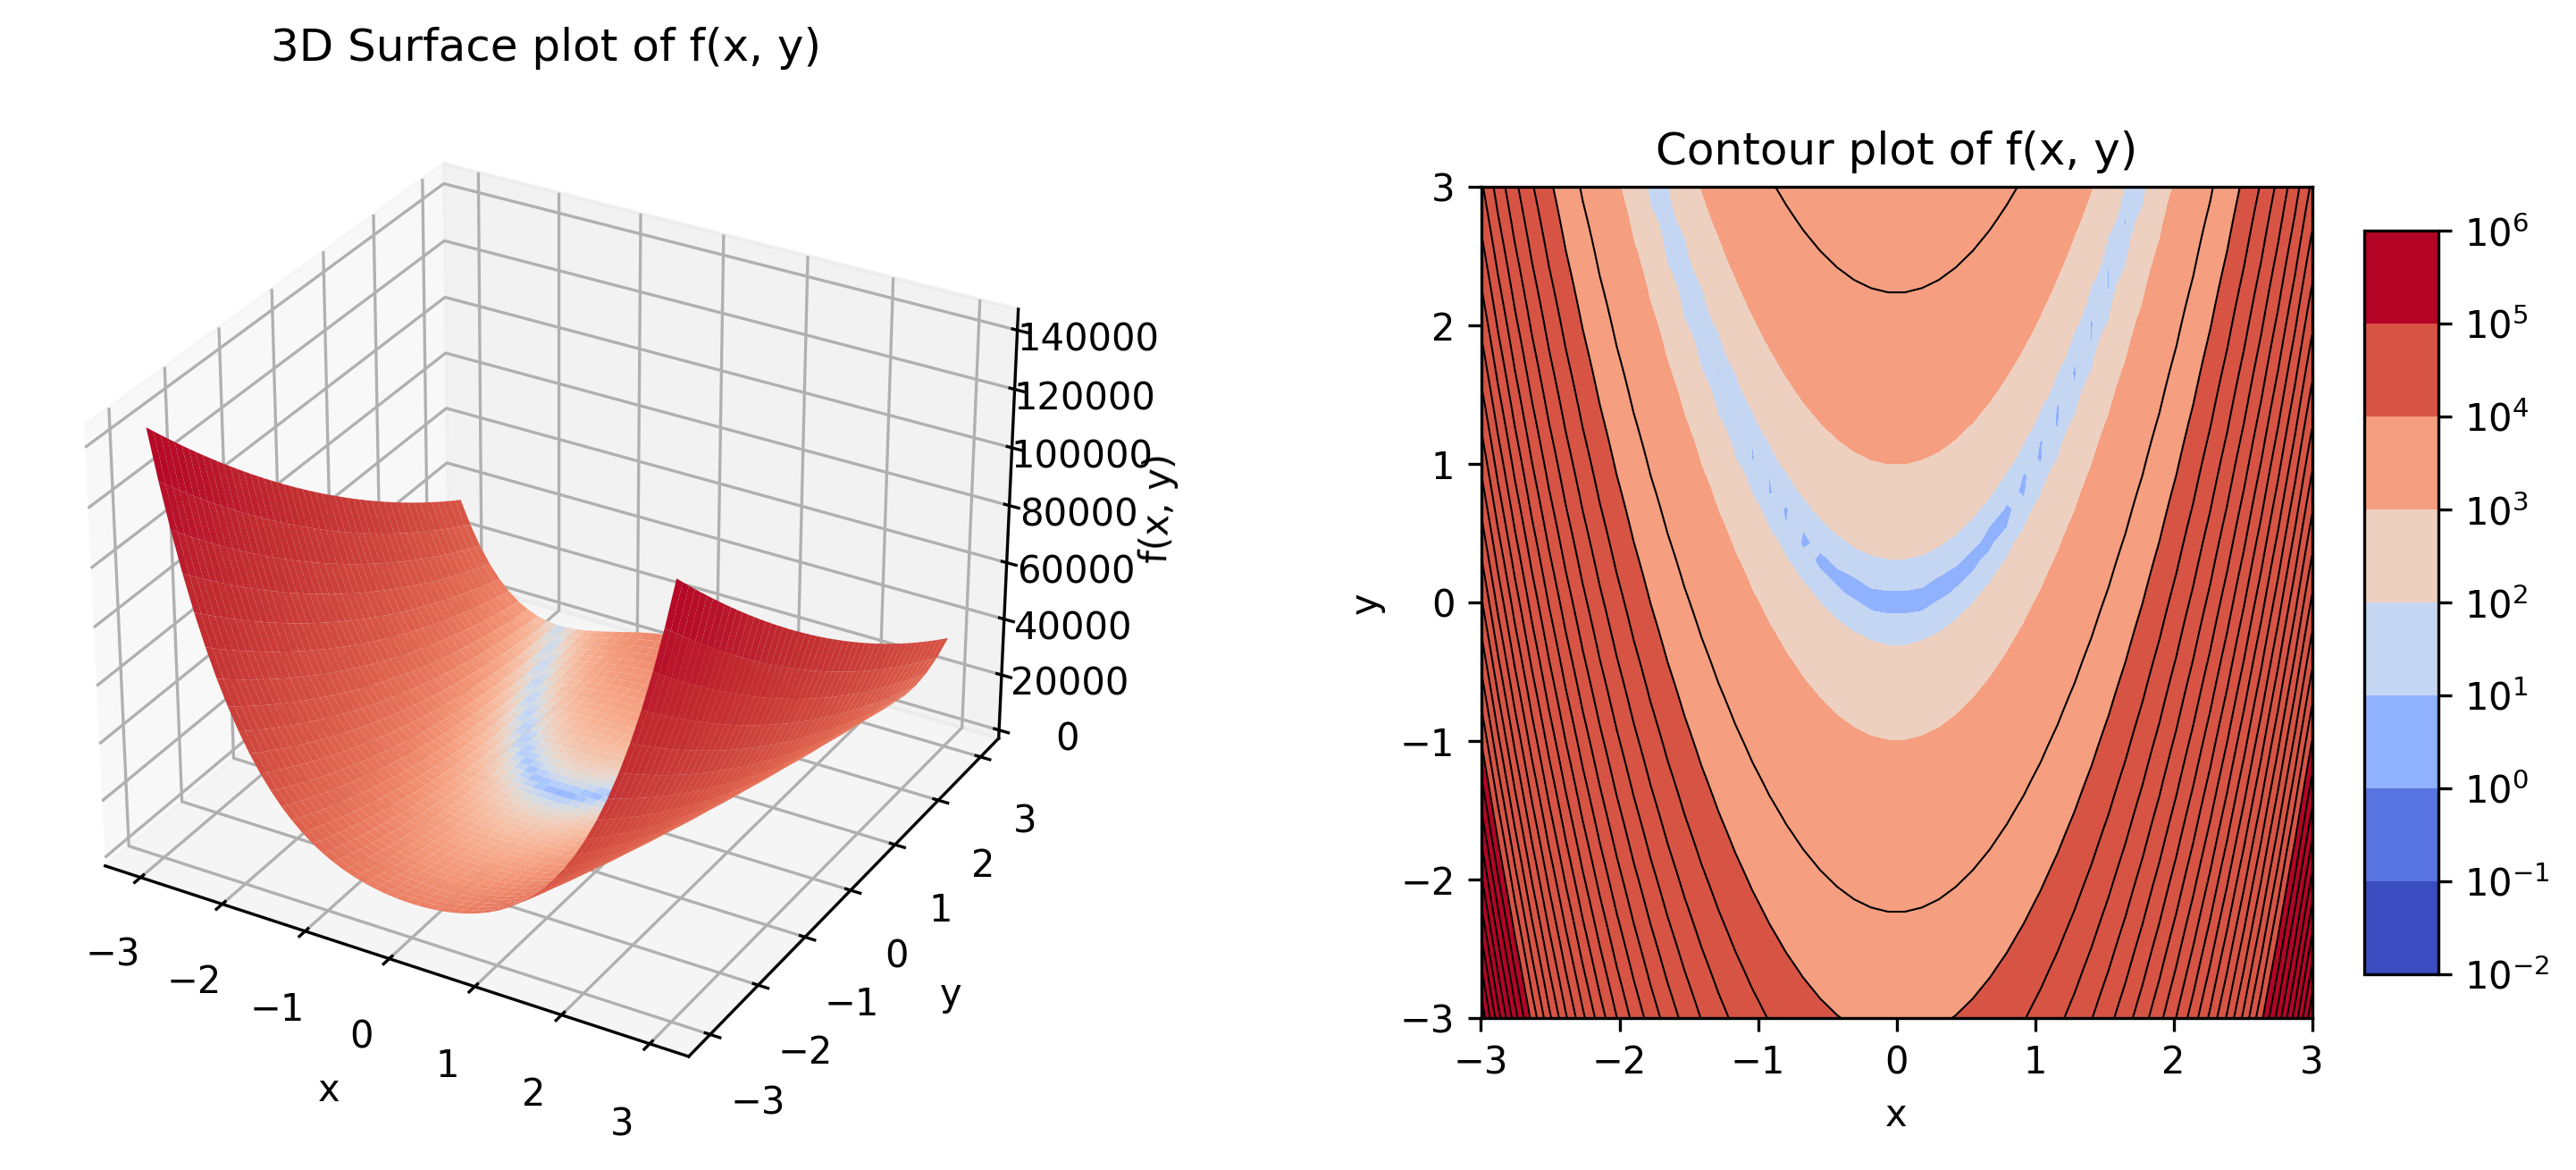

In [132]:
x_lim = [-3, 3]
y_lim = [-3, 3]

graph_combined(f_Rosenbrok_K1000, x_lim, y_lim, N_points=50)

where it can be seen how the values of the function along the x direction are significantly higher compared to the ones in the y direction, and much higher than in the previous case 

### Finding optimal value

OPTIMIZATION WITH STEEPEST DESCENDT 1
Optimal point:  [0.98950205 0.97966469]
Function value in optimal point:  0.0004131309480452439
Error:  2.19128184662647
Number of iterations:  50000



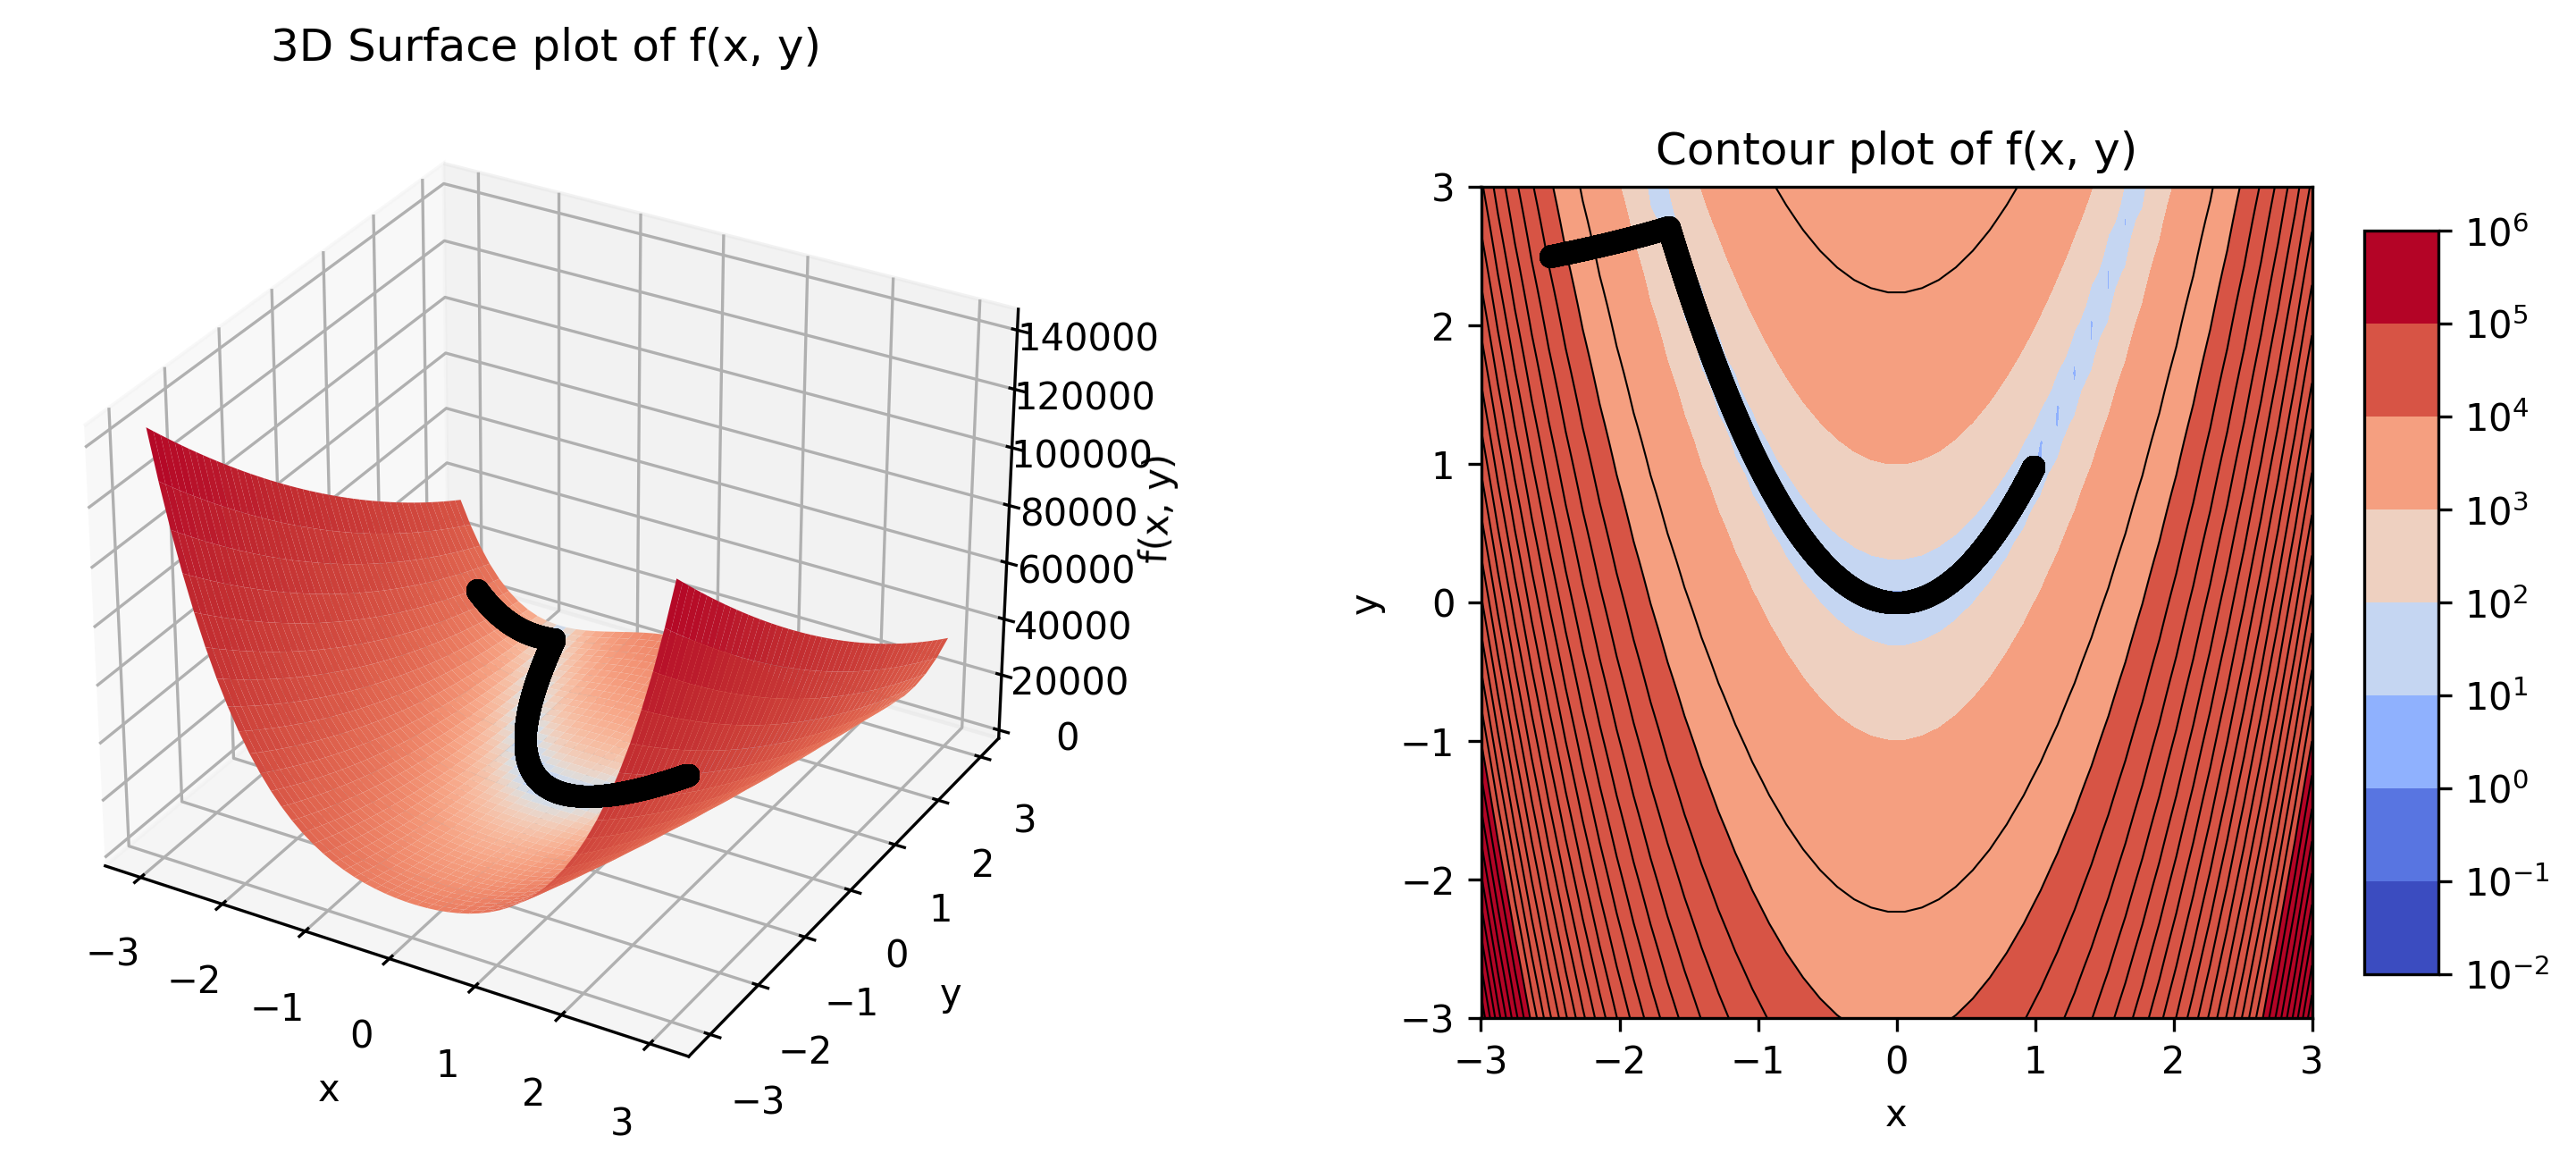

In [133]:
x_1, error1, steps1 = gradient_optimizer(f_Rosenbrok_K1000, x0, N_max=50000, d_alfa=0.0005, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K1000,"STEEPEST DESCENDT 1", x_1[-1], error1, steps1)
x_points = np.array([point[0] for point in x_1])
y_points = np.array([point[1] for point in x_1])
z_points = np.array([f_Rosenbrok_K1000(point) for point in x_1])  
fig1 = graph_combined(f_Rosenbrok_K1000, x_lim, y_lim, N_points=50, x_points=x_points, y_points=y_points, z_points=z_points)

In [134]:
x0 = [-2.5, 2.5] 

x_1, error1, steps1 = gradient_optimizer(f_Rosenbrok_K1000, x0, N_max=20000, d_alfa=0.8, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K1000,"STEEPEST DESCENDT 1 d_alfa=0.8", x_1[-1], error1, steps1)

x_2, error2, steps2 = gradient_optimizer(f_Rosenbrok_K1000, x0, N_max=20000, d_alfa=0.1, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K1000,"STEEPEST DESCENDT 2 d_alfa=0.1", x_2[-1], error2, steps2)

x_3, error3, steps3 = gradient_optimizer(f_Rosenbrok_K1000, x0, N_max=50000, d_alfa=0.0005, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K1000,"STEEPEST DESCENDT 2 d_alfa=0.0005", x_3[-1], error3, steps3)

result = minimize(f_Rosenbrok_K1000, x0, method='BFGS')
print_optimization_results(f_Rosenbrok_K1000, "BGS", result.x, np.linalg.norm(grad(f_Rosenbrok_K1000)(result.x), ord=np.inf), result.nit)


OPTIMIZATION WITH STEEPEST DESCENDT 1 d_alfa=0.8
Optimal point:  [ 0.04473965 -0.78889271]
Function value in optimal point:  626.4263877347272
Error:  14.706160979989107
Number of iterations:  20000

OPTIMIZATION WITH STEEPEST DESCENDT 2 d_alfa=0.1
Optimal point:  [ 0.1508334 -0.0618236]
Function value in optimal point:  7.873898302771733
Error:  38.17704331715571
Number of iterations:  20000

OPTIMIZATION WITH STEEPEST DESCENDT 2 d_alfa=0.0005
Optimal point:  [0.98950205 0.97966469]
Function value in optimal point:  0.0004131309480452439
Error:  2.19128184662647
Number of iterations:  50000

OPTIMIZATION WITH BGS
Optimal point:  [0.99997047 0.99994052]
Function value in optimal point:  1.0499511018897415e-09
Error:  0.0016283378713543486
Number of iterations:  71



The Wolfe conditions had to be disabled because they would require such a small step size to avoid looping that it would result in unacceptably long computation times. 

In the results we can see that for a given step size, the optimization process gets stuck and increasing the number of steps does not make an improvement. To improve acuracy the step size needs to be reduced significantly. The representation for each case can be seen in the following figures.

As it can be seen even the BFGS method requires some steps.

Representation of cases 1, 2, 3 respectively:

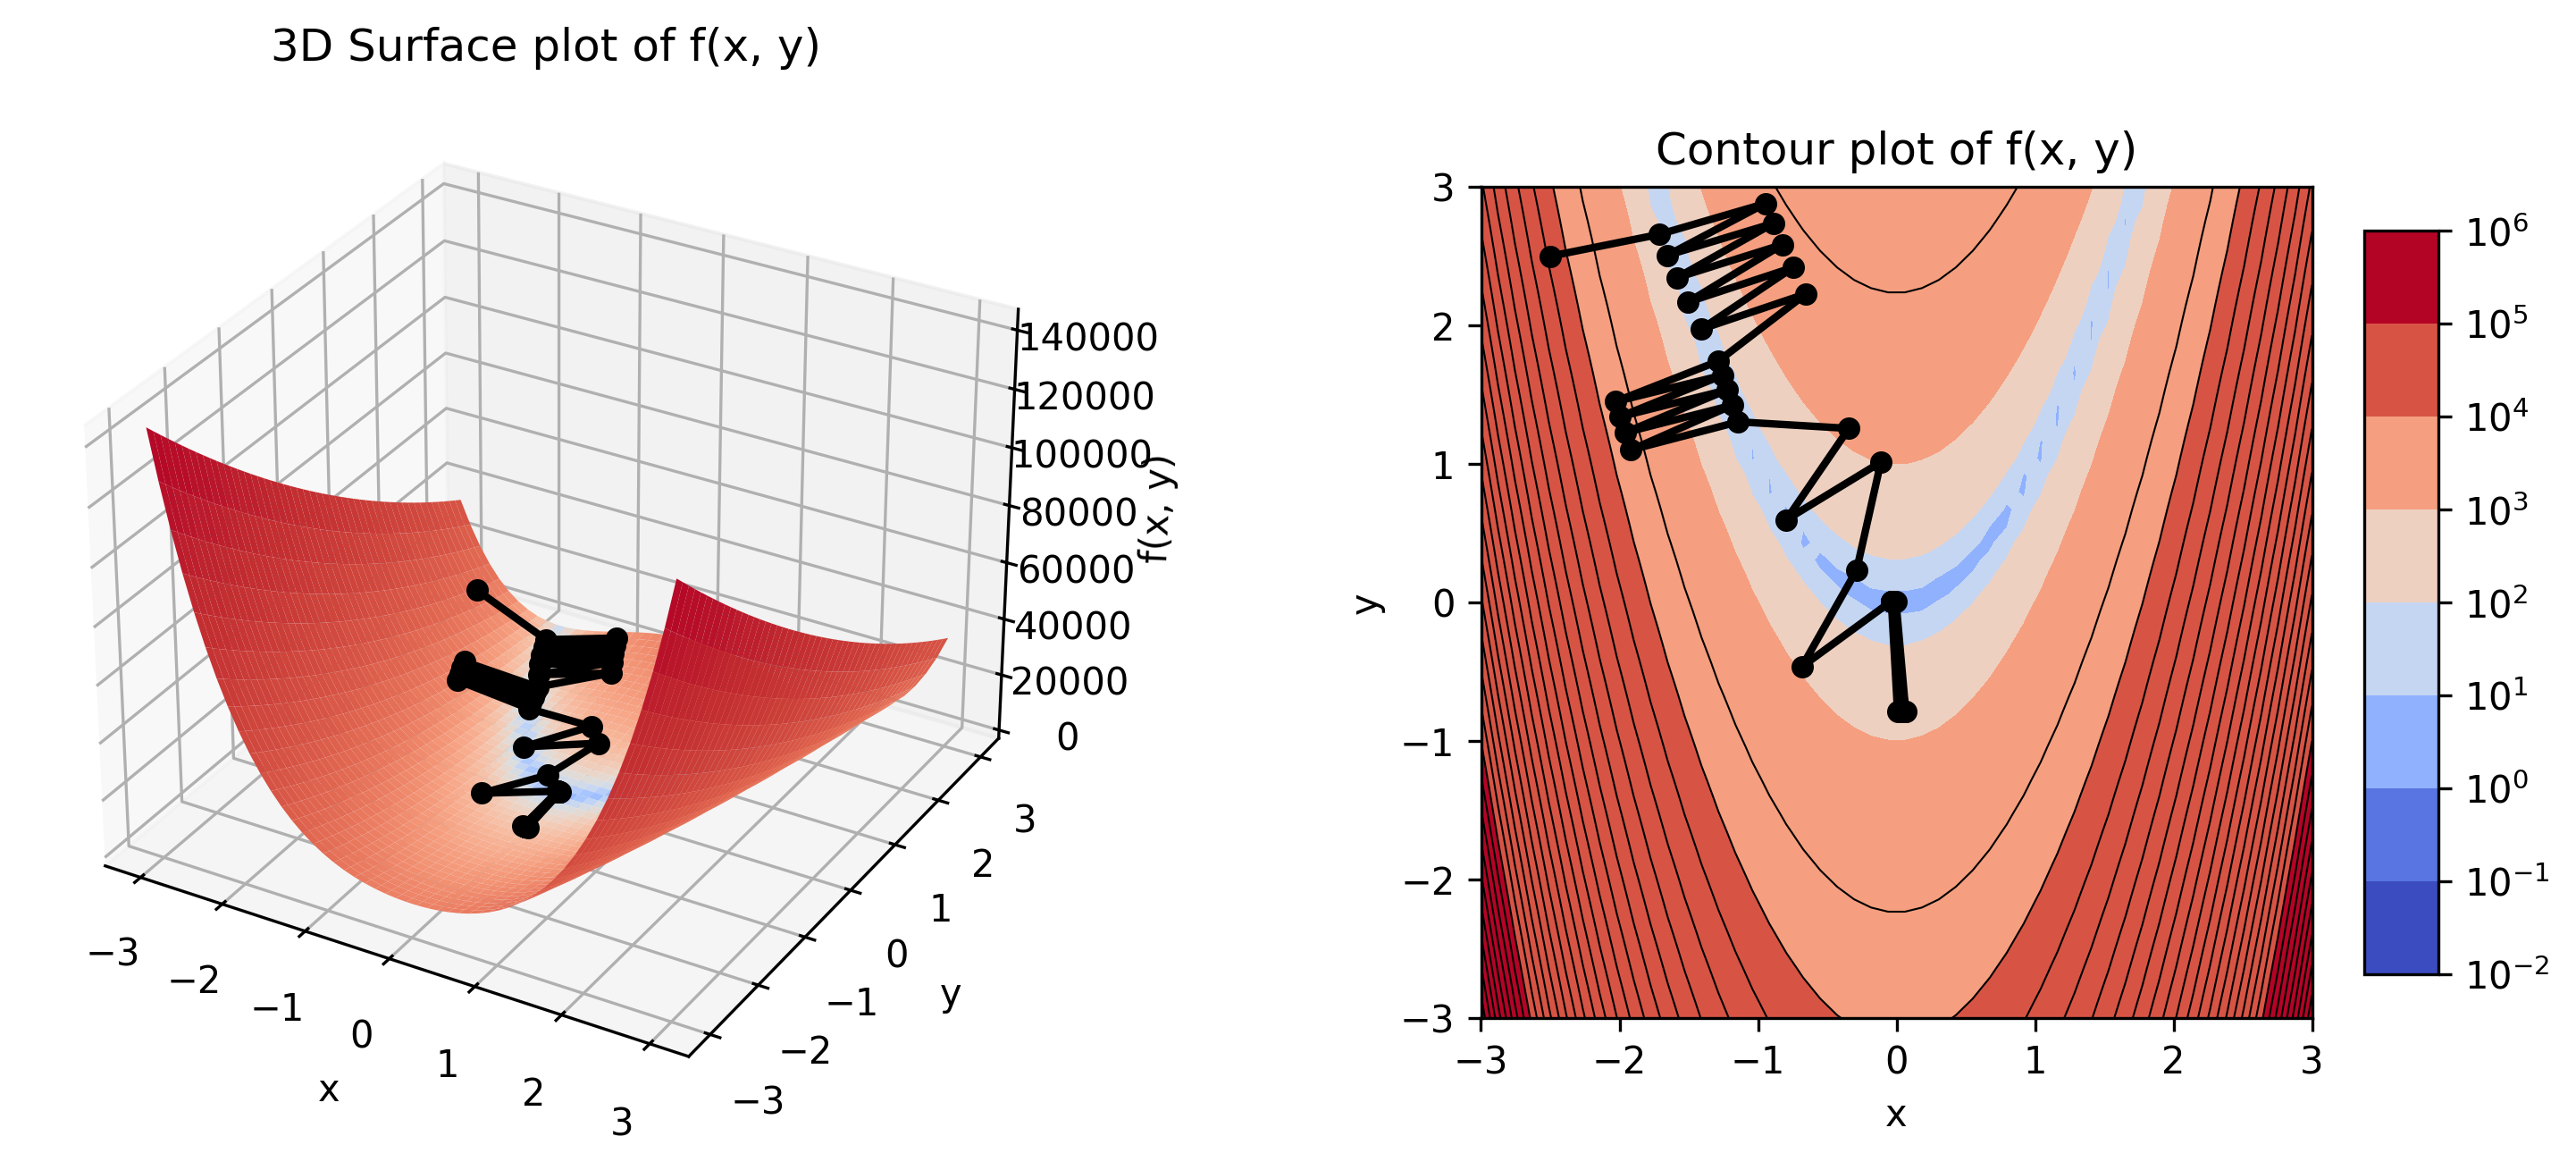

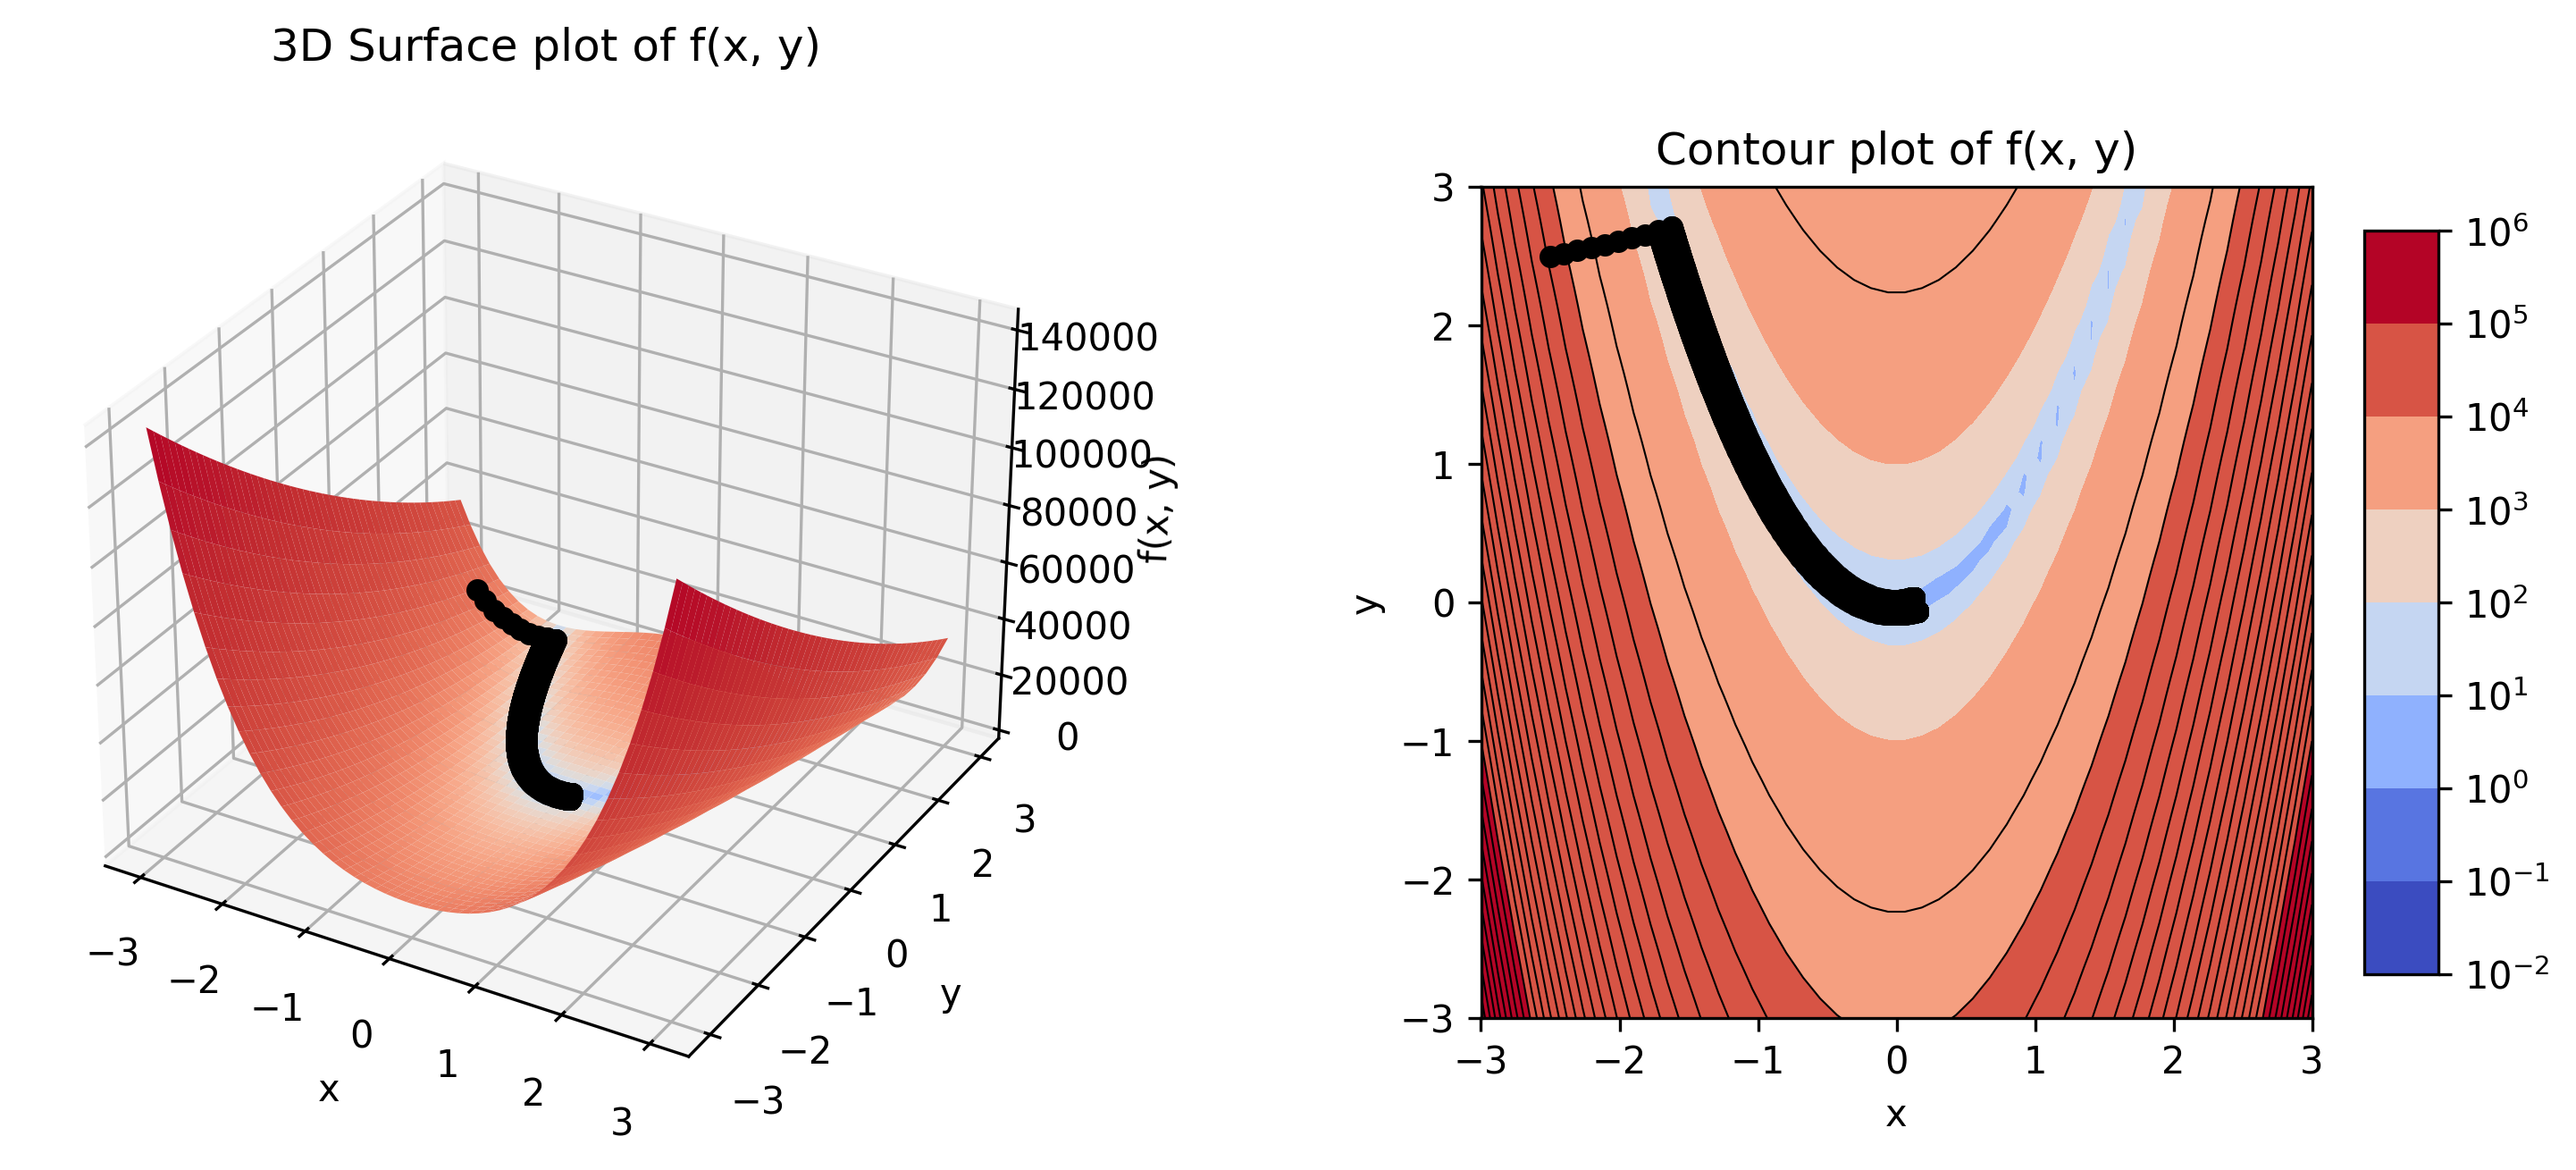

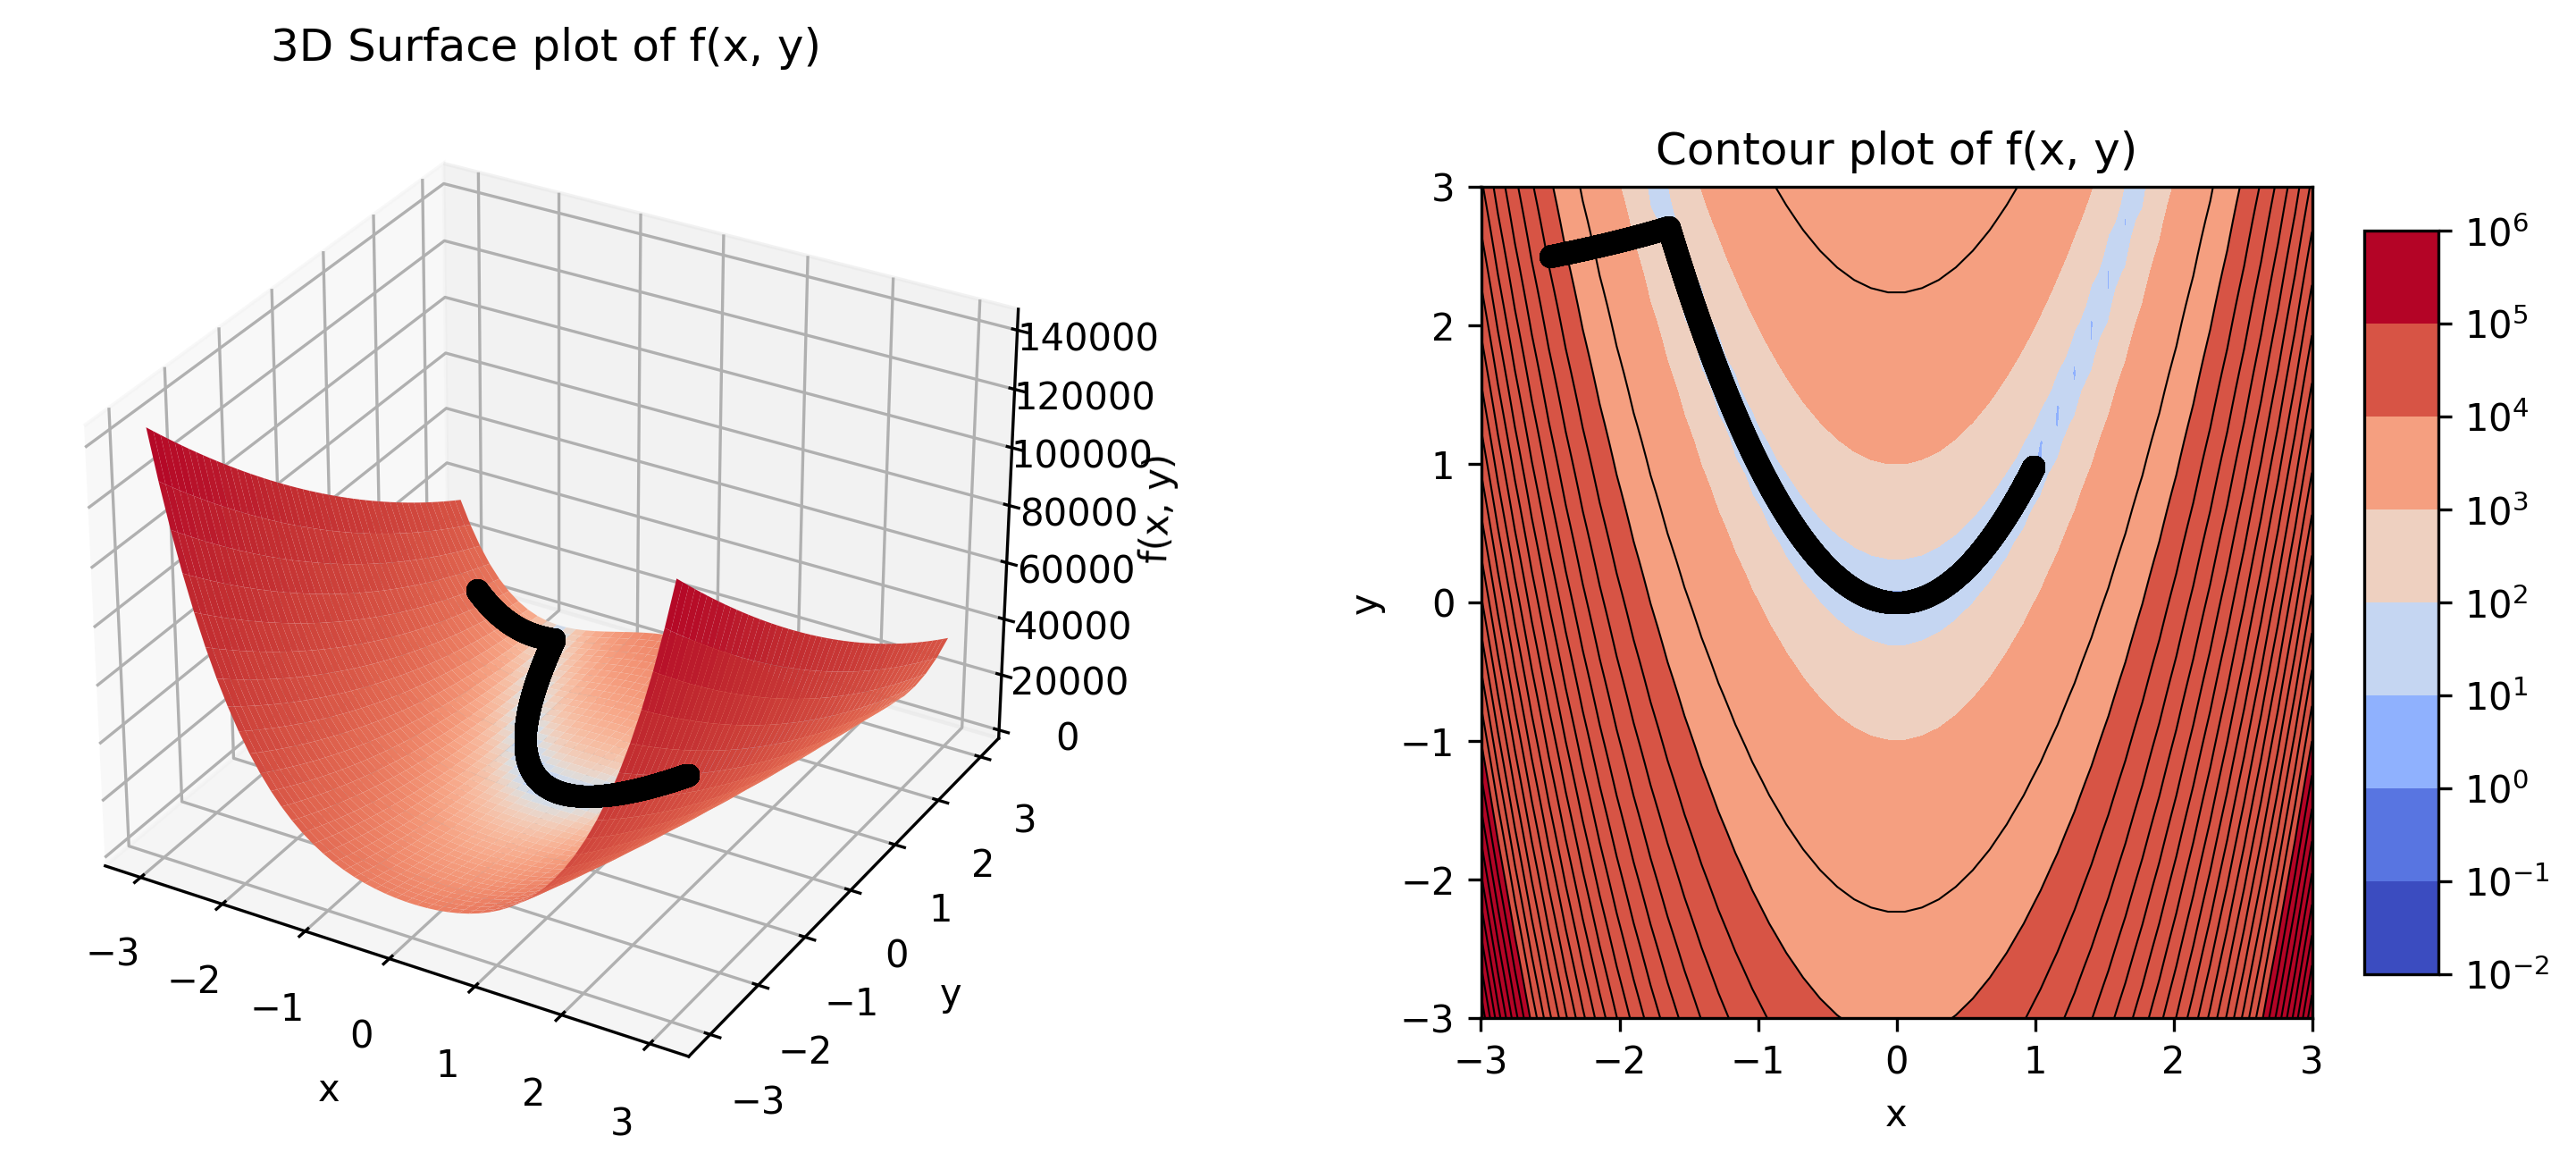

In [135]:
points_list = [x_1, x_2, x_3]

for i, points in enumerate(points_list, start=1):
    x_points = np.array([point[0] for point in points])
    y_points = np.array([point[1] for point in points])
    z_points = np.array([f_Rosenbrok_K1000(point) for point in points])
    fig = graph_combined(f_Rosenbrok_K1000, x_lim, y_lim, N_points=50, x_points=x_points, y_points=y_points, z_points=z_points)

### Normalising variables before finding optimal 

To fix the great espatial function values for each variables we can perform a variable change of the x1:

$$
\hat{x}_1 = \frac{x_1}{10^4}
$$


In [136]:
def f_Rosenbrok_K1000_normalized(x):
    """
    Normalizing the first component of the input data used by the function.

    Args:
        x (_type_): vector of components of the function

    Returns:
        function: normalised x1 Rosenbrok function with K=1000
    """
    normalising_value = 10 ** 4
    normalising_index = 0   # x1

    x_normalized = np.copy(x) 
    x_normalized[normalising_index] = x[normalising_index] / normalising_value
    
    f_Rosenbrok_K1000 = Rosenbrok_de_K(1000)
    return f_Rosenbrok_K1000(x_normalized)

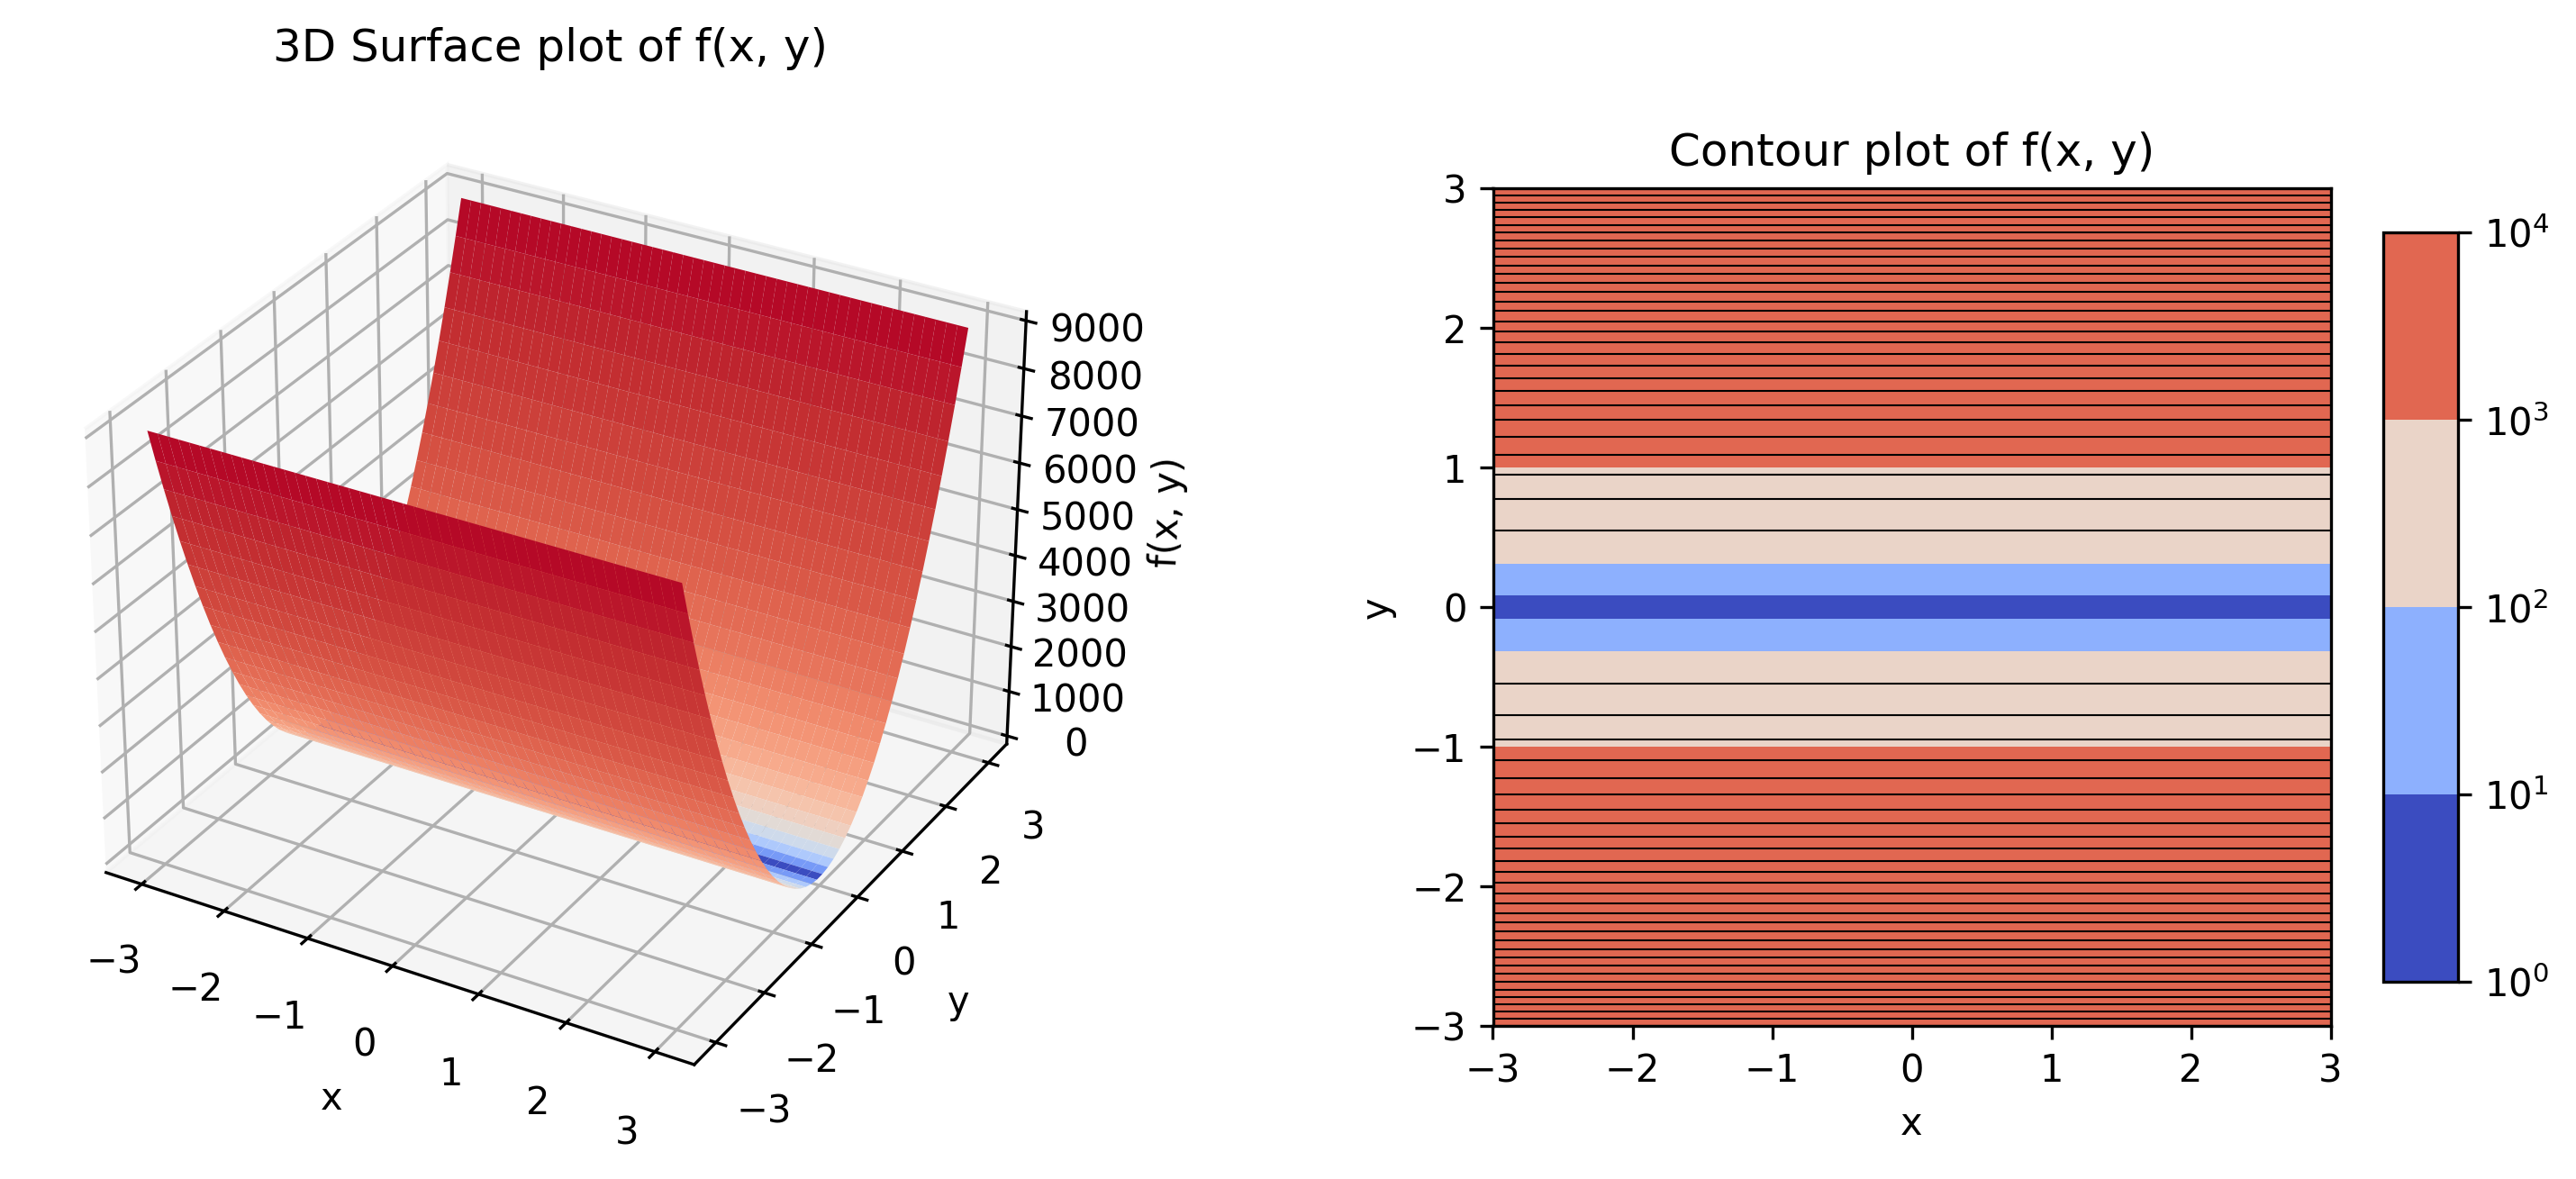

In [137]:
x_lim = [-3, 3]
y_lim = [-3, 3]

graph_combined(f_Rosenbrok_K1000_normalized, x_lim, y_lim, N_points=50)

Values for the normalized function in x1 with 10000, have significant smaller values.

In [138]:
x0 = [9999., 2.5] 
x_, error, steps = gradient_optimizer(f_Rosenbrok_K1000_normalized, x0, N_max=300, d_alfa=0.01, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K1000_normalized,"STEEPEST DESCENDT", x_[-1], error, steps)

x0 = [-2.5, 2.5] 
from scipy.optimize import minimize
result = minimize(f_Rosenbrok_K1000_normalized, x0, method='BFGS')
print_optimization_results(f_Rosenbrok_K1000_normalized, "BGS", result.x, np.linalg.norm(grad(f_Rosenbrok_K1000_normalized)(result.x), ord=np.inf), result.nit)


OPTIMIZATION WITH STEEPEST DESCENDT
Optimal point:  [9.99900030e+03 1.00000003e+00]
Function value in optimal point:  3.99939979824377e-05
Error:  19.6000803880092
Number of iterations:  300

OPTIMIZATION WITH BGS
Optimal point:  [9.99985097e+03 9.99970187e-01]
Function value in optimal point:  2.2214895367142624e-10
Error:  1.469179156110556e-05
Number of iterations:  48



With the normalized function, the steepest descent method requires significantly fewer steps to reach the solution. However, it is important to note that the initial point must be close to the optimal values, as the new variable can be far from the original initial point. Additionally, the solutions obtained correspond to the new variable, so the variable transformation must be reversed to obtain the solution in the original variables.

$$
x_{1_{\text{opt}}} = \hat{x}_{1_{\text{opt}}} \cdot 10^4
$$

It is also noteworthy that, even when using the original initial point for the optimization in the transformed variables, the BFGS method still manages to find the solution quickly, despite the point being initially far from the optimum

## Rosenbrook function for 10 variables K=100

In [139]:
f_Rosenbrok_K100 = Rosenbrok_de_K(100)

In [140]:
x0 = [-2.,1., 2., 2.5, -2.5, 1.1, 2.4, 1.9, -2.] 

x_, error, steps = gradient_optimizer(f_Rosenbrok_K100, x0, d_alfa= 0.01, N_max=3000, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K100,"STEEPEST DESCENDT", x_[-1], error, steps)


result = minimize(f_Rosenbrok_K100, x0, method='BFGS')
print_optimization_results(f_Rosenbrok_K100, "BGS", result.x, np.linalg.norm(grad(f_Rosenbrok_K100)(result.x), ord=np.inf), result.nit)

OPTIMIZATION WITH STEEPEST DESCENDT
Optimal point:  [-0.99292103  0.99275133  0.99637533  0.98803258  0.98480894  0.96425517
  0.93428184  0.8703542   0.75781152]
Function value in optimal point:  4.026422297312063
Error:  4.359198358519439
Number of iterations:  3000

OPTIMIZATION WITH BGS
Optimal point:  [0.99999994 0.99999993 0.99999985 0.99999963 0.99999923 0.99999845
 0.99999705 0.99999411 0.99998806]
Function value in optimal point:  5.2101460357950994e-11
Error:  6.441463077343024e-05
Number of iterations:  114



For this case it can be seen how the steepest descendenct method has found a the local minimum, while the BGS given the same initial condition has found the global minimum of the function.

A initial condition sufficiently closer to the global minimum should be enough to find this solution

In [141]:
x0 = [0.9, 1.1, 1.1, 0.9, -0.9, 1.2, 1.4, 0.8, -1.] 

x_, error, steps = gradient_optimizer(f_Rosenbrok_K100, x0, d_alfa= 0.001, N_max=5000, apply_wolf=False)
print_optimization_results(f_Rosenbrok_K100,"STEEPEST DESCENDT", x_[-1], error, steps)

OPTIMIZATION WITH STEEPEST DESCENDT
Optimal point:  [0.99483921 0.98970038 0.97949493 0.95938437 0.9203625  0.8469422
 0.71700876 0.51326566 0.26058412]
Function value in optimal point:  0.3498634921648015
Error:  0.5720394166710108
Number of iterations:  5000



To find all the minimum values of the function, the basinhopping algorithm can be used, which explores multiple minimum values by making random jumps from the current minimum. The starting point for basinhopping is the global minimum obtained from a genetic algorithm.

In [142]:
from scipy.optimize import differential_evolution, basinhopping
import numpy as np

## Finding global minimum with genetic algoritm within bounds
bounds = [(-10, 10)] * 10
global_result = differential_evolution(f_Rosenbrok_K100, bounds)

## Finding local minimums using global as reference
local_minima = []
def store_minima(x, f, accepted):
    if not any(np.allclose(x, m[0], atol=20e-5) for m in local_minima):
        local_minima.append((x, f))

minimizer_kwargs = {"method": "BFGS"}
basinhopping(f_Rosenbrok_K1000, global_result.x, minimizer_kwargs=minimizer_kwargs, niter=100, callback=store_minima)

for x, f in local_minima:
    print(f"Minimum: {x}, Function value: {f}")

Minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], Function value: 5.0005802242421694e-21
Minimum: [-0.99930971  0.99962007  0.99974032  0.99973075  0.9995864   0.9992352
  0.99850161  0.99702008  0.99405508  0.98814549], Function value: 3.998620370214753
